# 1 Motivation




The project that we choose is Skin Lesion Classification Using Deep Learning.
As melanoma is one of the deadliest types of skin cancer, we chose this topic because of the urgent need to enhance the early detection of skin cancer. Defects on or under the skin are collectively known as skin lesions. We can divide them into two broad categories. The first category is benign skin tumors, these are lesions, such as moles or cysts. The second category is malignant tumor, which refers to malignant skin lesions, such as melanoma, basal cell carcinoma. Although skin lesions are common, they are often difficult to identify by their appearance, and it remains difficult to automatically identify malignant tumors from dermoscopic images. Therefore, we want to do a successful deep learning strategy which can identify dermoscopic lesions.

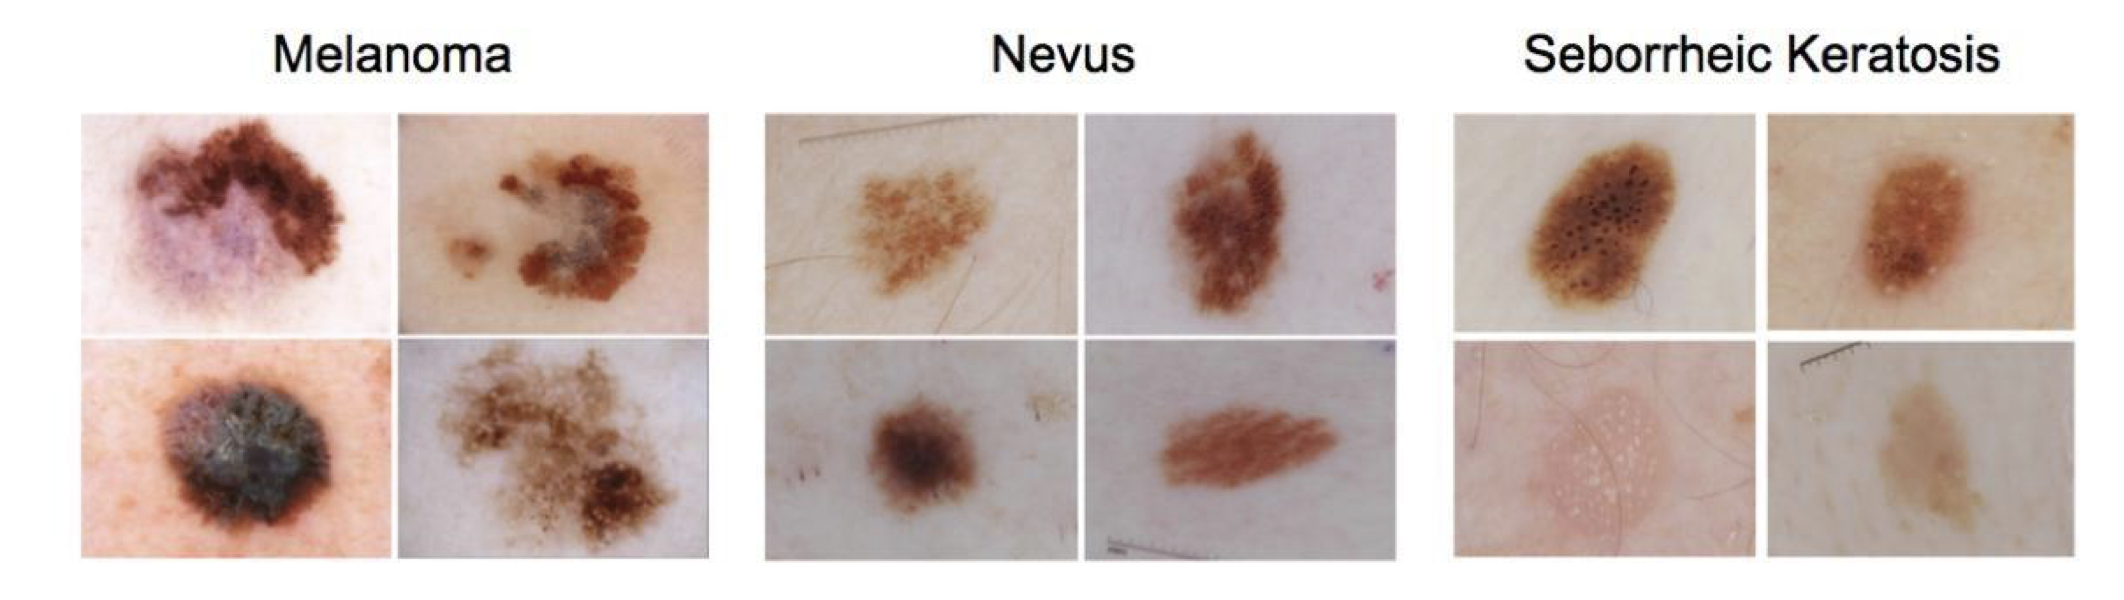

# **4 Models and Methods**


## **4.3 Model - Feature Extraction (ResNet101)**



We used the resnet101 model in addition to the resnet50 model.

In this image you can see a detailed structural comparison of the resnet family model. resnet50 and resnet101 are basically the same, the only difference is that resnet50 has six blocks with three layers here in conv4_x, and resnet101 has 23 blocks with three layers here.



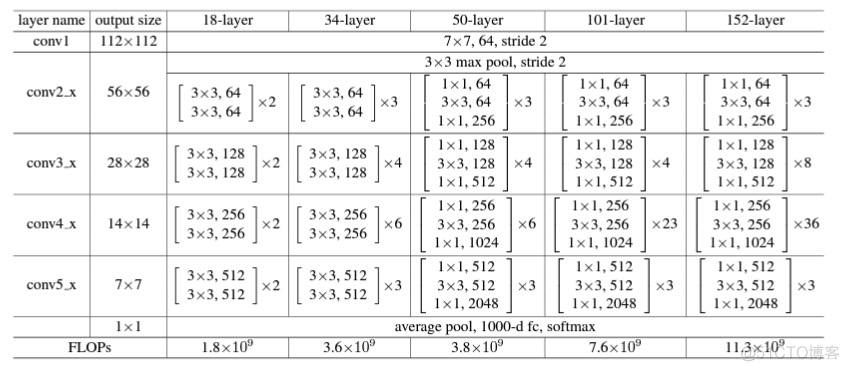

The only difference we can see here between resnet50 and resnet101 is the number of layers. resent101 has 51 more layers than resnet50. Because ResNet101 has more layers than resnet50, it can learn more features for better results. You can see this in our code results below, which show that ResNet101 does a lot better than resnet50.

Comput Loss



```
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()
```



BCEWithLogitsLoss is used because it uses logits to calculate the loss directly, avoiding the problems associated with numerical instability that can occur when the output is passed through the Sigmoid function alone before binary cross-entropy is applied.

Optimiser



```
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
```



Adam calculates the adaptive learning rate for each parameter. It adjusts the learning rate according to the first and second moments of the gradient, which helps the optimizer be more stable and efficient. Adam uses a form of momentum by considering the moving average of the gradient. This helps the optimizer maintain direction when gradient fluctuations occur, which can lead to faster convergence.

Metrics



```
from torchmetrics import Accuracy, AUROC, JaccardIndex

f1 = F1Score(task = "multilabel",num_labels=8).to("cuda")
accuracy = Accuracy(task="multilabel", num_labels=8).to("cuda")
auc = AUROC(task="multilabel", num_labels=8).to("cuda")

```





1.F1 Score


The F1 score is the harmonic average of accuracy and recall. Because we do a multi-label classification task, we want to make sure that our model not only correctly identifies relevant instances, but also finds most of them. The F1 Score provides a balance between the two, helping to evaluate the model's performance in correctly identifying each label.


2.Accuracy

Accuracy measures the proportion of correctly predicted labels among all predictions. It can provide a direct measure of overall correctness. For the multi-label problem, it takes into account the exact match rate, that is, the entire set of predicted labels must match the real label, which is more stringent than the traditional precision metric.

3.AUROC

AUROC assesses the model's ability to distinguish categories by plotting true and false positive rates at different threshold Settings.
A high AUROC value indicates that the model has a good measure of separability, meaning that it can effectively distinguish between positive and negative classes.

### **4.3.1 Original Data - Resnet101 With Fully Connected Layer**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify the file paths here
csv_file_path = '/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
image_files = data['image'].values
labels = data.drop(['image', 'UNK'], axis=1).values

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 of 0.8 = 0.2

# Define a custom dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training, validation, and testing datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir = image_folder_path, transform=transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir = image_folder_path, transform=transform)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir = image_folder_path, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# print(len(train_dataset))
# print(len(val_dataset))
# print(len(test_dataset))


Original Dataset Compute Loss


In [ ]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

Original Dataset with Model-Resnet101


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import timm
model_name = 'resnet101'
model = timm.create_model(model_name, pretrained=True, num_classes=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Original Dataset Optimiser



In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

Original Dataset Metrics

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 48.1 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy, AUROC, JaccardIndex

f1 = F1Score(task = "multilabel",num_labels=8).to("cuda")
accuracy = Accuracy(task="multilabel", num_labels=8).to("cuda")
auc = AUROC(task="multilabel", num_labels=8).to("cuda")


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Original Dataset Train and Validation with Linear Processing

In [ ]:
import time

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50):

    start = time.time()
    history = []
    best_loss = float('inf')
    best_epoch = None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch: {epoch+1}/{epochs}")

        model.train()

        train_loss = 0.0
        valid_loss = 0.0

        accuracy.reset()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels.float())

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * images.size(0)

            accuracy.update(outputs, labels.float())

        train_accuracy = accuracy.compute()

        model.eval()
        accuracy.reset()

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels.float())

                valid_loss += loss.item() * images.size(0)

                accuracy.update(outputs, labels)

        val_accuracy = accuracy.compute()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_valid_loss = valid_loss / len(val_loader.dataset)

        history.append([avg_train_loss, avg_valid_loss, train_accuracy, val_accuracy])

        epoch_end = time.time()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f},"
              f" Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Time: {epoch_end-epoch_start:.4f}s")


        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pt')

    return model, history, best_epoch


trained_model, history, best_epoch = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50)
torch.save(history, 'training_history.pt')


Epoch: 1/50
Epoch 1/50, Train Loss: 0.2127, Val Loss: 0.1833, Train Accuracy: 0.9181, Val Accuracy: 0.9258, Time: 4151.9488s
Epoch: 2/50
Epoch 2/50, Train Loss: 0.1647, Val Loss: 0.1579, Train Accuracy: 0.9343, Val Accuracy: 0.9392, Time: 131.5656s
Epoch: 3/50
Epoch 3/50, Train Loss: 0.1391, Val Loss: 0.1555, Train Accuracy: 0.9444, Val Accuracy: 0.9386, Time: 134.3398s
Epoch: 4/50
Epoch 4/50, Train Loss: 0.1122, Val Loss: 0.1421, Train Accuracy: 0.9561, Val Accuracy: 0.9450, Time: 133.2520s
Epoch: 5/50
Epoch 5/50, Train Loss: 0.0899, Val Loss: 0.1470, Train Accuracy: 0.9653, Val Accuracy: 0.9447, Time: 133.8333s
Epoch: 6/50
Epoch 6/50, Train Loss: 0.0734, Val Loss: 0.1746, Train Accuracy: 0.9718, Val Accuracy: 0.9397, Time: 133.5878s
Epoch: 7/50
Epoch 7/50, Train Loss: 0.0513, Val Loss: 0.1708, Train Accuracy: 0.9810, Val Accuracy: 0.9456, Time: 133.6534s
Epoch: 8/50
Epoch 8/50, Train Loss: 0.0394, Val Loss: 0.1794, Train Accuracy: 0.9859, Val Accuracy: 0.9445, Time: 133.4544s
Epoch: 

Original Dataset Train and Validation Visualization

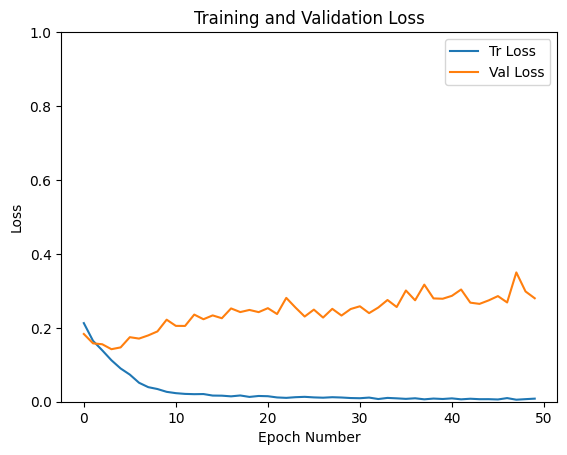

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 0], label='Tr Loss')
plt.plot(history[:, 1], label='Val Loss')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Training and Validation Loss')
plt.savefig('loss_curve.png')
plt.show()


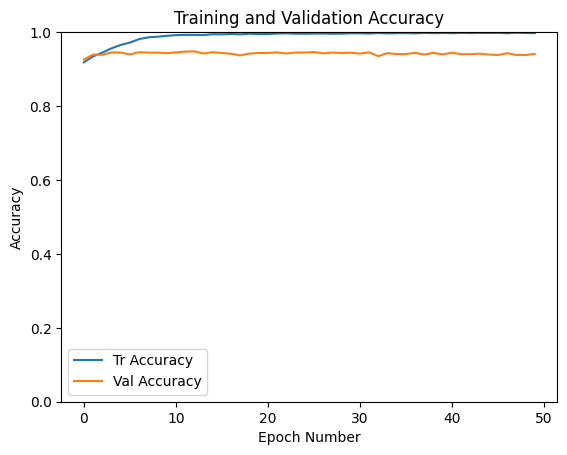

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 2], label='Tr Accuracy')
plt.plot(history[:, 3], label='Val Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()


Loss, Accuracy, F1 Score, AUROC using Original Test Dataset


In [ ]:
def computeTestSetMetrics(model, loss_criterion, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_loss = 0.0
    total_samples = 0

    accuracy = Accuracy(task="multilabel", num_labels=8).to(device)
    f1 = F1Score(task="multilabel", num_labels=8).to(device)

    auc_per_label = [AUROC(task="binary").to(device) for _ in range(8)]
    overall_auc = AUROC(task="multilabel", num_labels=8).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        model.eval()

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_criterion(outputs, labels.float())
            test_loss += loss.item() * inputs.size(0)

            all_preds.append(outputs)
            all_labels.append(labels)

            accuracy.update(outputs, labels)
            f1.update(outputs, labels)

            for i in range(8):
                auc_per_label[i].update(outputs[:, i], labels[:, i])

            overall_auc.update(outputs, labels)
            total_samples += inputs.size(0)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        avg_test_loss = test_loss / total_samples
        avg_test_acc = accuracy.compute().item()
        auc_scores = [auc.compute().item() for auc in auc_per_label]
        f1_score = f1.compute().item()
        overall_auc_score = overall_auc.compute().item()

        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {avg_test_acc:.4f}")
        print(f"Test F1 Score: {f1_score:.4f}")
        print(f"Overall AUC: {overall_auc_score:.4f}")

        for i, auc_score in enumerate(auc_scores):
            print(f"Test AUC for label {i}: {auc_score:.4f}")

    return avg_test_loss, avg_test_acc, auc_scores, f1_score, overall_auc_score

computeTestSetMetrics(trained_model, criterion, test_loader)


Test Loss: 0.2840
Test Accuracy: 0.9404
Test F1 Score: 0.7524
Overall AUC: 0.9350
Test AUC for label 0: 0.8861
Test AUC for label 1: 0.9367
Test AUC for label 2: 0.9604
Test AUC for label 3: 0.9280
Test AUC for label 4: 0.9015
Test AUC for label 5: 0.9578
Test AUC for label 6: 0.9781
Test AUC for label 7: 0.9314
(0.284, 0.9404, [0.8860601782798767, 0.936693549156189, 0.9604355096817017, 0.928024411201477, 0.9014753699302673, 0.9577605128288269, 0.9781057834625244, 0.9314019680023193], 0.7524, 0.935)


### **4.3.2 Original Data - Resnet101 With SVM**

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.resnet import ResNet101_Weights
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score,, roc_auc_score, accuracy_score
import numpy as np
import torch.nn as nn

# Load a pretrained ResNet101 model without the final fully connected layer
weights = ResNet101_Weights.DEFAULT
model = models.resnet101(weights=weights)
model.fc = nn.Identity()  # Remove the final layer

# Transfer model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

def extract_features(data_loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().numpy())
            labels_batch = convert_one_hot_to_indices(labels_batch)
            labels.extend(labels_batch.cpu().numpy())
    return np.array(features), np.array(labels)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Assume train_loader and test_loader are defined
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Train SVM
svm_classifier = SVC(kernel='poly', degree=3, C=1.0, random_state=42, probability=True)
svm_classifier.fit(train_features, train_labels)

# Evaluate SVM
test_predictions = svm_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)

print('Results for Data Processed With Cubic SVM Classifications Option')
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
#print(classification_report(test_labels, test_predictions))

# Compute metrics
f1 = f1_score(test_labels, test_predictions, average='weighted')
probabilities = svm_classifier.predict_proba(test_features)
auc = roc_auc_score(test_labels, probabilities, multi_class='ovr', average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# Calculate AUROC for each label
num_labels = len(np.unique(train_labels))
auc_scores_per_label = []

for i in range(num_labels):
    binary_labels = (test_labels == i).astype(int)
    binary_probabilities = probabilities[:, i]
    auc_per_label = roc_auc_score(binary_labels, binary_probabilities)
    auc_scores_per_label.append(auc_per_label)
    print(f"AUROC for label {i}: {auc_per_label:.4f}")



Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:00<00:00, 212MB/s]
Results for Data Processed With Cubic SVM Classifications Option
Test Set Accuracy: 71.03%
F1 Score: 0.6812
AUC Score: 0.9124
AUROC for label 0: 0.8788
AUROC for label 1: 0.9210
AUROC for label 2: 0.9381
AUROC for label 3: 0.9204
AUROC for label 4: 0.8833
AUROC for label 5: 0.8831
AUROC for label 6: 0.9716
AUROC for label 7: 0.9459


### **4.3.3 Processed Data - Resnet101 With Fully Connected Layer**

New Dataset preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Modify here
csv_file_path = '/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv'
image_folder_path = '/content/drive/MyDrive/ISIC_2019_Training_Input'

data = pd.read_csv(csv_file_path)

# Extract image filenames and labels
data['label'] = data.drop(['image', 'UNK'], axis=1).idxmax(axis=1)
image_files = data['image'].values
labels = data['label'].values

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Split the training set into training and validation sets
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42, stratify=train_data['label'])

# Set minimum and maximum sample sizes
min_samples = 2000
max_samples = 5000

balanced_train_data = pd.DataFrame()

class RandomRotate180:
    def __call__(self, img):
        if random.random() > 0.5:
            return img.rotate(180)
        return img

# Augmentation transforms for training data
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    RandomRotate180(),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ColorJitter(contrast=(0.5, 1.5))
])

# Common transforms for all data
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for label in train_data['label'].unique():
    label_data = train_data[train_data['label'] == label]
    count = len(label_data)

    if count < min_samples:
        n_samples = min(max_samples, max(min_samples, count * 2))
        n_augment = n_samples - count

        augmented_data = []
        for _, row in label_data.iterrows():
            img_name = os.path.join(image_folder_path, row['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_data.append([row['image'], label])

        for i in range(n_augment):
            img_name = os.path.join(image_folder_path, label_data.iloc[i % count]['image'] + ".jpg")
            image = Image.open(img_name).convert('RGB')
            augmented_image = augmentation_transforms(image)
            augmented_image_name = f"{label_data.iloc[i % count]['image']}_augmented_{i}"
            augmented_image_path = os.path.join(image_folder_path, augmented_image_name + ".jpg")

            # Save the augmented image only if it doesn't already exist
            if not os.path.exists(augmented_image_path):
                augmented_image.save(augmented_image_path)

            augmented_data.append([augmented_image_name, label])

        augmented_df = pd.DataFrame(augmented_data, columns=['image', 'label'])
        label_data = pd.concat([label_data, augmented_df])

    elif count > max_samples:
        n_samples = max(min_samples, int(count * 0.8))
        label_data = resample(label_data, replace=False, n_samples=n_samples, random_state=42)

    balanced_train_data = pd.concat([balanced_train_data, label_data])

# Separate the image filenames and labels of the training set
train_images = balanced_train_data['image'].values
train_labels = pd.get_dummies(balanced_train_data['label']).values

# Separate the image filenames and labels of the validation set
val_images = val_data['image'].values
val_labels = pd.get_dummies(val_data['label']).values

# Separate the image filenames and labels of the test set
test_images = test_data['image'].values
test_labels = pd.get_dummies(test_data['label']).values

# Define the dataset class
class SkinDiseaseDataset(Dataset):
    def __init__(self, image_files, labels, image_dir, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx] + ".jpg")
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Image transformation for training data
train_transform = transforms.Compose([
    augmentation_transforms,
    common_transforms
])

# Create training, validation, and test datasets
train_dataset = SkinDiseaseDataset(train_images, train_labels, image_dir=image_folder_path, transform=train_transform)
val_dataset = SkinDiseaseDataset(val_images, val_labels, image_dir=image_folder_path, transform=common_transforms)
test_dataset = SkinDiseaseDataset(test_images, test_labels, image_dir=image_folder_path, transform=common_transforms)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Check if balanced
# train_counts = balanced_train_data['label'].value_counts()
# val_counts = val_data['label'].value_counts()
# test_counts = test_data['label'].value_counts()

# print("Training set label counts:")
# print(train_counts)
# print("\nValidation set label counts:")
# print(val_counts)
# print("\nTest set label counts:")
# print(test_counts)


New Dataset Compute Loss

In [ ]:
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

New Dataset with Model-Resnet101

In [ ]:
!pip install timm

In [ ]:
import timm
model_name = 'resnet101'
model = timm.create_model(model_name, pretrained=True, num_classes=8)

New Dataset Optimiser

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001)

New Dataset Metric

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 48.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy, AUROC, JaccardIndex

f1 = F1Score(task = "multilabel",num_labels=8).to("cuda")
accuracy = Accuracy(task="multilabel", num_labels=8).to("cuda")
auc = AUROC(task="multilabel", num_labels=8).to("cuda")


New Dataset Train and Validation with Linear Processing


In [ ]:
import time

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50):

    start = time.time()
    history = []
    best_loss = float('inf')
    best_epoch = None

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch: {epoch+1}/{epochs}")

        model.train()

        train_loss = 0.0
        valid_loss = 0.0

        accuracy.reset()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)

            loss = criterion(outputs, labels.float())

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * images.size(0)

            accuracy.update(outputs, labels.float())

        train_accuracy = accuracy.compute()

        model.eval()
        accuracy.reset()

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)

                loss = criterion(outputs, labels.float())

                valid_loss += loss.item() * images.size(0)

                accuracy.update(outputs, labels)

        val_accuracy = accuracy.compute()

        avg_train_loss = train_loss / len(train_loader.dataset)
        avg_valid_loss = valid_loss / len(val_loader.dataset)

        history.append([avg_train_loss, avg_valid_loss, train_accuracy, val_accuracy])

        epoch_end = time.time()

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_valid_loss:.4f},"
              f" Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, Time: {epoch_end-epoch_start:.4f}s")


        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pt')

    return model, history, best_epoch


trained_model, history, best_epoch = train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs=50)
torch.save(history, 'training_history.pt')


Epoch: 1/50
Epoch 1/50, Train Loss: 0.2284, Val Loss: 0.1772, Train Accuracy: 0.9092, Val Accuracy: 0.9284, Time: 2308.4247s
Epoch: 2/50
Epoch 2/50, Train Loss: 0.1496, Val Loss: 0.2051, Train Accuracy: 0.9392, Val Accuracy: 0.9205, Time: 228.6533s
Epoch: 3/50
Epoch 3/50, Train Loss: 0.1169, Val Loss: 0.1698, Train Accuracy: 0.9531, Val Accuracy: 0.9331, Time: 229.0388s
Epoch: 4/50
Epoch 4/50, Train Loss: 0.0956, Val Loss: 0.1729, Train Accuracy: 0.9625, Val Accuracy: 0.9318, Time: 229.7345s
Epoch: 5/50
Epoch 5/50, Train Loss: 0.0820, Val Loss: 0.1401, Train Accuracy: 0.9677, Val Accuracy: 0.9470, Time: 229.1255s
Epoch: 6/50
Epoch 6/50, Train Loss: 0.0723, Val Loss: 0.1930, Train Accuracy: 0.9716, Val Accuracy: 0.9270, Time: 229.3223s
Epoch: 7/50
Epoch 7/50, Train Loss: 0.0613, Val Loss: 0.1496, Train Accuracy: 0.9758, Val Accuracy: 0.9462, Time: 228.9938s
Epoch: 8/50
Epoch 8/50, Train Loss: 0.0550, Val Loss: 0.1436, Train Accuracy: 0.9784, Val Accuracy: 0.9446, Time: 228.9056s
Epoch: 

New Dataset Train and Validation Visualization

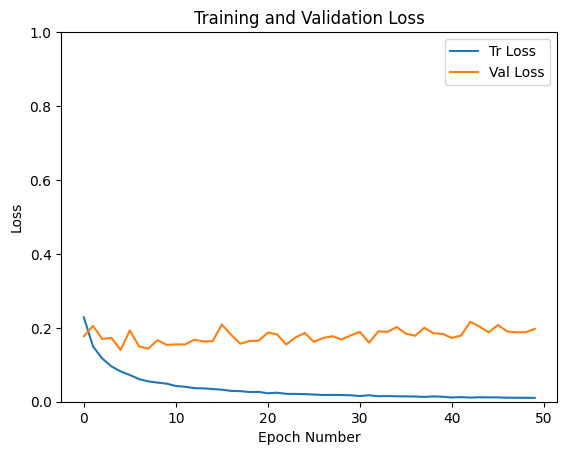

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 0], label='Tr Loss')
plt.plot(history[:, 1], label='Val Loss')
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Training and Validation Loss')
plt.savefig('loss_curve.png')
plt.show()


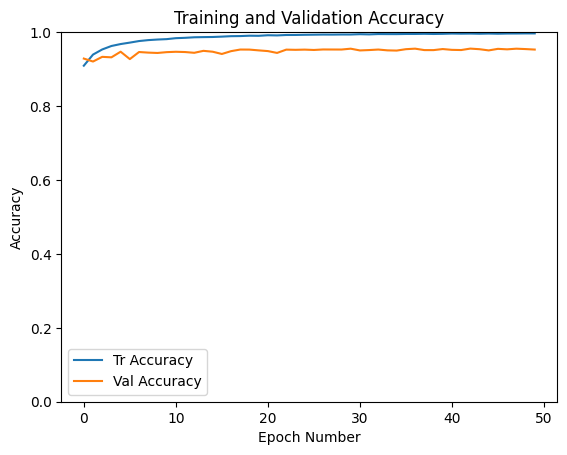

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

history = [[item.cpu().numpy() if torch.is_tensor(item) else item for item in sublist] for sublist in history]
history = np.array(history)


plt.plot(history[:, 2], label='Tr Accuracy')
plt.plot(history[:, 3], label='Val Accuracy')
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()


Loss, Accuracy, F1 Score, AUROC using New Test Dataset

In [ ]:
def computeTestSetMetrics(model, loss_criterion, test_loader, threshold=0.5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_loss = 0.0
    total_samples = 0

    accuracy = Accuracy(task="multilabel", num_labels=8).to(device)
    f1 = F1Score(task="multilabel", num_labels=8).to(device)

    auc_per_label = [AUROC(task="binary").to(device) for _ in range(8)]
    overall_auc = AUROC(task="multilabel", num_labels=8).to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        model.eval()

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            loss = loss_criterion(outputs, labels.float())
            test_loss += loss.item() * inputs.size(0)

            # Threshold outputs to obtain binary predictions
            binary_preds = (outputs >= threshold).int()

            all_preds.append(binary_preds)
            all_labels.append(labels.int())  # Ensure labels are integers

            accuracy.update(binary_preds, labels.int())
            f1.update(outputs, labels.int())

            for i in range(8):
                auc_per_label[i].update(outputs[:, i], labels[:, i].int())  # Ensure each label is an integer

            overall_auc.update(outputs, labels.int())  # Ensure labels are integers
            total_samples += inputs.size(0)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

        avg_test_loss = test_loss / total_samples
        avg_test_acc = accuracy.compute().item()
        auc_scores = [auc.compute().item() for auc in auc_per_label]
        f1_score = f1.compute().item()
        overall_auc_score = overall_auc.compute().item()

        print(f"Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {avg_test_acc:.4f}")
        print(f"Test F1 Score: {f1_score:.4f}")
        print(f"Overall AUC: {overall_auc_score:.4f}")

        for i, auc_score in enumerate(auc_scores):
            print(f"Test AUC for label {i}: {auc_score:.4f}")

    return avg_test_loss, avg_test_acc, auc_scores, f1_score, overall_auc_score

# Example usage
computeTestSetMetrics(trained_model, criterion, test_loader)


Test Loss: 0.2045
Test Accuracy: 0.9510
Test F1 Score: 0.7524
Overall AUC: 0.9531
Test AUC for label 0: 0.9597
Test AUC for label 1: 0.9735
Test AUC for label 2: 0.9315
Test AUC for label 3: 0.9633
Test AUC for label 4: 0.9049
Test AUC for label 5: 0.9494
Test AUC for label 6: 0.9467
Test AUC for label 7: 0.9960
(0.2045259605604256, 0.950957179069519, [0.9597277045249939, 0.9734513759613037, 0.9314782619476318, 0.963314414024353, 0.9048947691917419, 0.9494282007217407, 0.9467285871505737, 0.995954155921936], 0.5721563696861267, 0.9531221985816956)


### **4.3.4 Processed Data - Resnet101 With SVM**

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.resnet import ResNet101_Weights
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
import numpy as np
import torch.nn as nn

# Load a pretrained ResNet101 model without the final fully connected layer
weights = ResNet101_Weights.DEFAULT
model = models.resnet101(weights=weights)
model.fc = nn.Identity()  # Remove the final layer

# Transfer model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

def convert_one_hot_to_indices(labels):
    if labels.ndim > 1:  # Check if labels are one-hot encoded
        labels = torch.argmax(labels, dim=1)
    return labels

def extract_features(data_loader):
    features = []
    labels = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device)
            output = model(images)
            features.extend(output.cpu().numpy())
            labels_batch = convert_one_hot_to_indices(labels_batch)
            labels.extend(labels_batch.cpu().numpy())
    return np.array(features), np.array(labels)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Assume train_loader and test_loader are defined
train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

# Train SVM
svm_classifier = SVC(kernel='poly', degree=3, C=1.0, random_state=42, probability=True)
svm_classifier.fit(train_features, train_labels)

# Evaluate SVM
test_predictions = svm_classifier.predict(test_features)
accuracy = accuracy_score(test_labels, test_predictions)

print('Results for Data Processed With Cubic SVM Classifications Option')
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")
#print(classification_report(test_labels, test_predictions))

# Compute metrics
f1 = f1_score(test_labels, test_predictions, average='weighted')
probabilities = svm_classifier.predict_proba(test_features)
auc = roc_auc_score(test_labels, probabilities, multi_class='ovr', average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")

# Calculate AUROC for each label
num_labels = len(np.unique(train_labels))
auc_scores_per_label = []

for i in range(num_labels):
    binary_labels = (test_labels == i).astype(int)
    binary_probabilities = probabilities[:, i]
    auc_per_label = roc_auc_score(binary_labels, binary_probabilities)
    auc_scores_per_label.append(auc_per_label)
    print(f"AUROC for label {i}: {auc_per_label:.4f}")



Results for Data Processed With Cubic SVM Classifications Option
Test Set Accuracy: 70.42%
F1 Score: 0.6973
AUC Score: 0.9053
AUROC for label 0: 0.9204
AUROC for label 1: 0.9356
AUROC for label 2: 0.8707
AUROC for label 3: 0.9187
AUROC for label 4: 0.8581
AUROC for label 5: 0.9185
AUROC for label 6: 0.9218
AUROC for label 7: 0.9335
